### Обработка, чистка, добавление необходимой информации в массив.

In [77]:
from math import floor
import numpy as np
import pandas as pd
import re

In [78]:
# загрузка данных, которые были спарсины с помощью кода из 1 части
cian = pd.read_csv('/Users/issaya/Downloads/offers_data.csv', low_memory=False)

In [79]:
# достаем район из столбца 'address'
def extract_district(address):
    match = re.search(r'р-н ([^,]+)', address)  # Ищем текст после "р-н" и до запятой
    if match:
        return match.group(1)
    return None  # Если не найдено, возвращаем None


# Применяем функцию к столбцу
cian['district'] = cian['address'].apply(extract_district)

In [80]:
# приводим кол-во комнат в числовой формат
def clean_room(room):
    # Проверка на "roomN", где N от 1 до 6
    match = re.match(r'room(\d)', room)
    if match:
        N = int(match.group(1))
        if 1 <= N <= 6:
            return N  # Возвращаем количество комнат
        elif N == 7:
            return -1
        elif N == 9:
            return 0
    return room  # Если значение не подходит, возвращаем оригинальное

# Применяем функцию к столбцу room
cian['кол-во комнат'] = cian['room'].apply(clean_room)
# если студия, то кол-во комнат 0, если свободная планировка, то кол-во комнат -1

In [81]:
# переводим минуты на транспорте в минуты пешком через коэффициент
def process_time(row):
    if isinstance(row, str):
        words = row.split()
        time_value = int(words[0]) 
        last_word = words[-1] 

        # Если последнее слово "транспорте", умножаем на 0.15
        if last_word == "транспорте":
            return time_value * 0.15
        else:
            return time_value
    else:
        # Если это не строка, просто возвращаем значение
        return row

# Применяем функцию к столбцу
cian['время до метро (мин)'] = cian['metro_distance'].apply(process_time)

In [82]:
cian = cian.drop(['subtitle', 'metro_distance','rooms_count', 'seller_name', 'room', 'address'], axis=1)

In [83]:
# заменяем пустые значения при помощи формул
cian['floor'] = cian.groupby('metro')['floor'].transform(lambda x: x.fillna(x.mean()))
cian['total_floors'] = cian.groupby('metro')['total_floors'].transform(lambda x: x.fillna(x.mean()))
cian['area'] = cian.groupby('metro')['area'].transform(lambda x: x.fillna(x.mean()))
cian['area'] = cian['area'].fillna(cian['area'].mean())
cian['property_type'] = cian['property_type'].fillna(cian['property_type'].mode()[0])
cian['seller_type'] = cian['seller_type'].fillna("Нет данных")
cian['zhk_name'] = cian['zhk_name'].fillna("Нет данных")
cian['description'] = cian['description'].fillna("Нет данных")
cian['время до метро (мин)'] = cian['время до метро (мин)'].fillna(cian['время до метро (мин)'].mean())

In [84]:
# избавляемся от выброса
cian = cian[cian['price_per_m2'] != 6646526]

In [85]:
# делаем из районов дамми переменные

# Функция для создания дамми-переменных с использованием .loc[]
def create_dummy_variables(df):
    df.loc[:, 'Центральный'] = df['district'].apply(lambda x: 1 if x in ['Центральный', 'Невский', 'Адмиралтейский',
                                                                      'Василеостровский', 'Петроградский'] else 0)
    df.loc[:, 'Спальный'] = df['district'].apply(lambda x: 1 if x in ['Выборгский', 'Калининский', 'Кировский', 
                                                                   'Колпинский', 'Красногвардейский', 'Красносельский', 
                                                                   'Московский', 'Пушкинский', 'Фрунзенский'] else 0)
    df.loc[:, 'Прибрежный'] = df['district'].apply(lambda x: 1 if x in ['Василеостровский', 'Красносельский', 
                                                                    'Кронштадтский', 'Курортный', 'Приморский', 
                                                                    'Петродворцовый'] else 0)
    df.loc[:, 'Промышленный'] = df['district'].apply(lambda x: 1 if x in ['Калининский', 'Кировский', 'Колпинский', 
                                                                       'Кронштадтский', 'Московский'] else 0)
    return df

# Создаем дамми-переменные
cian = create_dummy_variables(cian)
cian

,id,title,link,price,price_per_m2,metro,floor,total_floors,area,property_type,...,rosreestr_verified,zhk_name,description,district,кол-во комнат,время до метро (мин),Центральный,Спальный,Прибрежный,Промышленный
0,307260103,"1-комн. квартира, 44 м², 7/9 этаж",https://spb.cian.ru/sale/flat/307260103/,5325000,121023,Шушары,7,9,51,квартира,...,False,ЖК «Вариант»,На земельном участке в Шушарах (м/р Ленсоветов...,Пушкинский,1,2,0,1,0,0
1,314584858,"1-комн. квартира, 4 362 м², 5/9 этаж",https://spb.cian.ru/sale/flat/314584858/,17990000,4124,Черная речка,5,9,362,квартира,...,False,"ЖК «Черная речка, 41»",Арт. 97119898 Продается 1-комнатная квартира 4...,Приморский,1,10,0,0,1,0
2,313145340,"1-комн. квартира, 32,2 м², 4/12 этаж",https://spb.cian.ru/sale/flat/313145340/,3900000,121118,Шушары,4,12,32,квартира,...,False,Нет данных,"Продается однокомнатная квартира, комната хоро...",Колпинский,1,3,0,1,0,1
3,314634835,Просторная однокомнатная квартира,https://spb.cian.ru/sale/flat/314634835/,5341234,115113,Ладожская,1,5,46,апартаменты,...,False,Нет данных,Oднокoмнaтная у м. Ладожcкая в зеленой чaсти г...,Красногвардейский,1,2,0,1,0,0
4,313323424,"1-комн. квартира, 32 м², 2/9 этаж",https://spb.cian.ru/sale/flat/313323424/,3913000,122281,Проспект Ветеранов,2,9,32,квартира,...,True,Нет данных,"Реaлизуетcя имущeство, в собственнoсти AО Т-Бa...",Красносельский,1,2,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29216,309824071,"Апартаменты-студия, 42,1 м², 11/12 этаж",https://spb.cian.ru/sale/flat/309824071/,31120024,739193,Зеленогорск,11,12,55,квартира,...,False,ЖК «МФК Морская ривьера»,"""Морская Ривьера"" уникальный комплекс апартаме...",Курортный,0,1,0,0,1,0
29217,306247027,"Студия, 21,2 м², 2/9 этаж",https://spb.cian.ru/sale/flat/306247027/,11064280,521900,Балтийская,2,9,62,квартира,...,False,ЖК «Лермонтовский 54»,"Продаётся квартира-студия площадью 21,2 кв.м н...",Адмиралтейский,0,4,1,0,0,0
29218,314667708,"1-комн. квартира, 30,9 м², 3/9 этаж",https://spb.cian.ru/sale/flat/314667708/,4800000,155340,Гражданский проспект,3,9,31,квартира,...,True,Нет данных,КУПИТЕ квартиру в городе по цене студии! - Ква...,Калининский,0,1,0,1,0,1
29219,313170735,"1-комн. квартира, 32,1 м², 1/12 этаж",https://spb.cian.ru/sale/flat/313170735/,5350000,166667,Проспект Просвещения,1,12,32,квартира,...,False,Нет данных,ID: 1912152 Однушка - надо брать! 15 мин пешко...,Выборгский,0,16,0,1,0,0


In [86]:
# делим 
def categorize_floors(floor):
    if 1 <= floor <= 2:
        return "[1-2]"
    elif 3 <= floor <= 4:
        return "[3-4]"
    elif 5 <= floor <= 10:
        return "[5-10]"
    elif 11 <= floor <= 20:
        return "[11-20]"
    else:
        return "[>20]"

cian["floor_group"] = cian["total_floors"].apply(categorize_floors)

In [87]:
# ищем в описании префикс 'срочн' и добавляем новый столбец
def check_urgent_sale(text):
    if pd.isna(text):  # Проверяем на NaN
        return "Несрочная продажа"
    return "Срочная продажа" if re.search(r"\bсрочн", text, re.IGNORECASE) else "Несрочная продажа"

# Применяем функцию к столбцу "description"
cian["Срочная_продажа"] = cian["description"].apply(check_urgent_sale)

In [88]:
# выбираем нужные столбцы
cian = cian[['price_per_m2', 'metro', 'district', 'floor', 'total_floors', 'area', 'property_type', 'seller_type', 'documents_verified', 'super_agent', 'rosreestr_verified', 'zhk_name', 'кол-во комнат', 'время до метро (мин)', 'floor_group', 'Центральный', 'Спальный', 'Прибрежный', 'Промышленный', 'Срочная_продажа']]

In [89]:
# переименовываем
cian.rename(columns={'metro': 'Метро', 'floor' : 'Этаж_квартиры', 'price_per_m2': 'Цена_за_метр', 
                     'total_floors' : 'Этажность_здания', 'area': 'Площадь_помещения', 'property_type': 'Тип_недвижимости',
                     'documents_verified' : 'Документы_проверены', 'super_agent': 'Супер_агент', 
                     'rosreestr_verified': 'Росреестр_проверено', 'zhk_name' : 'Название_ЖК', 'кол-во комнат':'Кол-во_комнат', 
                     'время до метро (мин)': 'Время_до_метро', 'district':'Район'}, inplace=True)

/var/folders/bm/39vh_d456d388sl7tv8xtz540000gn/T/ipykernel_52264/2840974038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cian.rename(columns={'metro': 'Метро', 'floor' : 'Этаж_квартиры', 'price_per_m2': 'Цена_за_метр',


In [90]:
# приводим группы этажности к категориальным переменным
def replace_floor_group(value):
    if value == '[1-2]':
        return 1
    elif value == '[3-4]':
        return 2
    elif value == '[5-10]':
        return 3
    elif value == '[11-20]':
        return 4
    elif value == '[>20]':
        return 5
    return value  # Если значение не найдено, оставляем его без изменений

# Применяем функцию к столбцу 'floor_group'
cian['Группа_этажности'] = cian['floor_group'].apply(replace_floor_group)

/var/folders/bm/39vh_d456d388sl7tv8xtz540000gn/T/ipykernel_52264/2846786549.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cian['Группа_этажности'] = cian['floor_group'].apply(replace_floor_group)


In [91]:
# заменяем True и False
cian = cian.replace({True: 1, False: 0})

/var/folders/bm/39vh_d456d388sl7tv8xtz540000gn/T/ipykernel_52264/2282158547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cian = cian.replace({True: 1, False: 0})


In [92]:
# приводим к категориальным переменным
cian['Тип_недвижимости'] = cian['Тип_недвижимости'].replace({'квартира': 1, 'апартаменты': 0})

/var/folders/bm/39vh_d456d388sl7tv8xtz540000gn/T/ipykernel_52264/4058105043.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cian['Тип_недвижимости'] = cian['Тип_недвижимости'].replace({'квартира': 1, 'апартаменты': 0})


In [93]:
# меняем тип столбцов
cian[['Этаж_квартиры', 'Этажность_здания']] = cian[['Этаж_квартиры', 'Этажность_здания']].astype(int)

In [94]:
# меняем на категориальные переменные
cian['Срочная_продажа'] = cian['Срочная_продажа'].replace({'Несрочная продажа': 0, 'Срочная продажа': 1})

/var/folders/bm/39vh_d456d388sl7tv8xtz540000gn/T/ipykernel_52264/2098518576.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cian['Срочная_продажа'] = cian['Срочная_продажа'].replace({'Несрочная продажа': 0, 'Срочная продажа': 1})


In [95]:
cian

,Цена_за_метр,Метро,Район,Этаж_квартиры,Этажность_здания,Площадь_помещения,Тип_недвижимости,seller_type,Документы_проверены,Супер_агент,...,Название_ЖК,Кол-во_комнат,Время_до_метро,floor_group,Центральный,Спальный,Прибрежный,Промышленный,Срочная_продажа,Группа_этажности
0,121023,Шушары,Пушкинский,7,9,51,1,ПРЕДСТАВИТЕЛЬ ЗАСТРОЙЩИКА,0,0,...,ЖК «Вариант»,1,2,[5-10],0,1,0,0,0,3
1,4124,Черная речка,Приморский,5,9,362,1,АГЕНТСТВО НЕДВИЖИМОСТИ,1,0,...,"ЖК «Черная речка, 41»",1,10,[5-10],0,0,1,0,0,3
2,121118,Шушары,Колпинский,4,12,32,1,АГЕНТСТВО НЕДВИЖИМОСТИ,1,0,...,Нет данных,1,3,[11-20],0,1,0,1,0,4
3,115113,Ладожская,Красногвардейский,1,5,46,0,УК・ОФ.ПРЕДСТАВИТЕЛЬ,1,0,...,Нет данных,1,2,[5-10],0,1,0,0,0,3
4,122281,Проспект Ветеранов,Красносельский,2,9,32,1,АГЕНТСТВО НЕДВИЖИМОСТИ,1,0,...,Нет данных,1,2,[5-10],0,1,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29216,739193,Зеленогорск,Курортный,11,12,55,1,ЗАСТРОЙЩИК,0,0,...,ЖК «МФК Морская ривьера»,0,1,[11-20],0,0,1,0,0,4
29217,521900,Балтийская,Адмиралтейский,2,9,62,1,ЗАСТРОЙЩИК,0,0,...,ЖК «Лермонтовский 54»,0,4,[5-10],1,0,0,0,0,3
29218,155340,Гражданский проспект,Калининский,3,9,31,1,РИЕЛТОР,0,1,...,Нет данных,0,1,[5-10],0,1,0,1,0,3
29219,166667,Проспект Просвещения,Выборгский,1,12,32,1,АГЕНТСТВО НЕДВИЖИМОСТИ,1,0,...,Нет данных,0,16,[11-20],0,1,0,0,0,4


Добавление загруженности метро

In [96]:
# парсим википедию с данными по каждой станции
pass_metro_21 = 603
pass_metro_22 = 622
pass_metro_23 = 627
pass_metro_24 = 686,1

import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://ru.wikipedia.org/wiki/%D0%9F%D0%B0%D1%81%D1%81%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%BF%D0%BE%D1%82%D0%BE%D0%BA_%D0%9F%D0%B5%D1%82%D0%B5%D1%80%D0%B1%D1%83%D1%80%D0%B3%D1%81%D0%BA%D0%BE%D0%B3%D0%BE_%D0%BC%D0%B5%D1%82%D1%80%D0%BE%D0%BF%D0%BE%D0%BB%D0%B8%D1%82%D0%B5%D0%BD%D0%B0"
response = requests.get(url)
if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    tables = soup.find_all("table", {"class": "wikitable"})
    all_tables_data = []
    for table in tables:
        headers = [th.get_text(strip=True) for th in table.find_all("th")]
        rows = []
        for tr in table.find_all("tr")[1:]:
            cells = [td.get_text(strip=True) for td in tr.find_all("td")]
            if cells:
                rows.append(cells)
        if headers and rows:
            df = pd.DataFrame(rows, columns=headers)
            all_tables_data.append(df)

    for i, df in enumerate(all_tables_data):
        print(f"Таблица {i + 1}:\n", df, "\n")

else:
    print(f"Ошибка при запросе страницы: {response.status_code}")

Таблица 1:
                        Станция Средний пассажиропоток за месяц (тыс.)
0                    Девяткино                               2142,011
1         Гражданский проспект                               1362,634
2                Академическая                               1289,715
3              Политехническая                                793,694
4             Площадь Мужества                                802,091
5                       Лесная                                773,211
6                   Выборгская                                928,701
7             Площадь Ленина 1                               1192,637
8             Площадь Ленина 2                                767,969
9                 Чернышевская                               1379,266
10         Площадь Восстания 1                               1294,423
11         Площадь Восстания 2                               1451,506
12                Владимирская                                806,363
13      

In [97]:
# форматируем полученные данные
combined_df = pd.concat(all_tables_data, ignore_index=True, sort=False)
combined_df["year_pass"] = combined_df['Средний пассажиропоток за месяц (тыс.)'].str.replace(',', '.').astype(float) * 12 / 1000
combined_df.drop('Средний пассажиропоток за месяц (тыс.)', axis=1, inplace=True)
combined_df = combined_df.sort_values(by='year_pass', ascending=False)
combined_df['Станция'] = combined_df['Станция'].fillna('нет данных').astype(str)
combined_df['Станция'] = combined_df['Станция'].str.capitalize()
combined_df['Станция'] = combined_df['Станция'].str.replace(r'\d+', '', regex=True)
combined_df['Станция'] = combined_df['Станция'].str.replace('ё', 'е')
combined_df['Станция'] = combined_df['Станция'].str.replace('выход', '')
combined_df['Станция'] = combined_df['Станция'].str.strip()
combined_df = combined_df.groupby('Станция', as_index=False)['year_pass'].sum()
combined_df = combined_df.sort_values(by='year_pass', ascending=False)
combined_df['Ранг'] = combined_df['year_pass'].rank(ascending=False, method='min').astype(int)

In [100]:
# добавляем к общему массиву
rank_dict = dict(zip(combined_df['Станция'], combined_df['Ранг']))
cian['Метро'] = cian['Метро'].str.capitalize()
cian['Метро'] = cian['Метро'].str.replace(r'\d+', '', regex=True)
cian['Метро'] = cian['Метро'].str.replace('ё', 'е')
cian['Ранг_метро'] = cian['Метро'].map(lambda x: rank_dict.get(x, 'нет информации'))


In [103]:
cian = cian[cian['Ранг_метро'] != 'нет информации']
cian['Ранг_метро'] = cian['Ранг_метро'].astype(int)

##### Сохранение итогового массива

In [104]:
cian.to_csv("cian_processed.csv", index=False, encoding="utf-8")

### Визуализация и описание данных

In [61]:
cian = cian[cian['Ранг_метро'] != 'нет информации']
cian['Ранг_метро'] = cian['Ранг_метро'].astype(float)

/var/folders/bm/39vh_d456d388sl7tv8xtz540000gn/T/ipykernel_52264/995829932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cian['Ранг_метро'] = cian['Ранг_метро'].astype(float)


In [62]:
pd.options.display.float_format = '{:,.0f}'.format
cian.describe()

,Цена_за_метр,Этаж_квартиры,Этажность_здания,Площадь_помещения,Тип_недвижимости,Документы_проверены,Супер_агент,Росреестр_проверено,Кол-во_комнат,Время_до_метро,Центральный,Спальный,Прибрежный,Промышленный,Срочная_продажа,Группа_этажности,Ранг_метро
count,"28,325","28,325","28,325","28,325","28,325","28,325","28,325","28,325","28,325","28,325","28,325","28,325","28,325","28,325","28,325","28,325","28,325"
mean,"264,010",6,12,61,1,0,0,0,2,6,0,0,0,0,0,3,26
std,"148,818",5,7,42,0,0,0,0,1,6,0,0,0,0,0,1,19
min,347,1,1,8,0,0,0,0,-1,0,0,0,0,0,0,1,1
25%,"182,741",3,6,38,1,0,0,0,1,1,0,0,0,0,0,3,11
50%,"228,117",5,10,52,1,0,0,0,2,3,0,0,0,0,0,3,20
75%,"292,647",9,16,70,1,1,0,0,3,11,1,1,1,0,0,4,40
max,"2,800,849",35,78,801,1,1,1,1,6,20,1,1,1,1,1,5,71


##### Цена_за_метр 
Представляет наше целевое значение, мы специально брали цену за квадратный метр, что легко сравнивать разные сегменты рынка: 
новостройки, вторичку, элитное жильё и бюджетное. Двухкомнатная квартира в 50 м² и однокомнатная в 30 м² могут стоить одинаково 
в абсолютных ценах, но их цена за квадратный метр будет отличаться. Это позволяет корректнее анализировать рынок.

##### Время_до_метро
Чем меньше минут пешком или на транспорте, тем выше цена за м². Сильный фактор.

##### Ранг_метро
Ранг метро показывает загруженность каждой станции. Мы предполагаем если пассажиропоток на станции высокий, цена за квадратный 
метр будет ниже в этом районе.
##### Центральный
Центральные районы Санкт Петербурга имеют богатую историю и славятся своими старинными зданиями. В таких районах цена за 
квадратный метр должна быть выше среднего.

##### Спальный
Спальные районы имеют среднюю цену за счет плотной застройки, но в то же время высокой степени инфраструктуры.

##### Прибрежный
Прибрежные районы, к примеру курортный или петродворцовый могут иметь прямое влияние на стоимость жилья, благодаря живописным видам, финскому заливу и хорошей инфраструктуре, так как они все еще находятся в пределах границы города.

##### Промышленные зоны
Обычно цена ниже на недвижимость в таких районах из-за шума, загрязненности воздуха и тд.

##### Этаж_квартиры
Средние этажи обычно дороже, чем первые и последние (из-за удобства и вида).

##### Этажность_здания
Новостройки в спальных районах в основном высокоэтажные, а в центре и курортных районах по большей части малоэтажная застройка. 
Можно предположить, что цена на высокоэтажные здания будет ниже.

##### Площадь_помещения
Влияет на цену за м² нелинейно. Маленькие квартиры (студии, 1-комнатные) обычно дороже за м², чем большие.

##### Кол-во_комнат
Меньше комнат → выше цена за м², больше комнат → дешевле за м² (но дороже в абсолютном значении).

'-1' - свободная планировка

'0' - студия

'1-6' - соответсвует кол-ву комнат.

##### Тип_недвижимости
0 - апартаменты. 1- квартира. Мы предполагаем, что квадратный метр квартиры будет стоить дешевле квадратного метра апартаментов. Так как в основном апартаменты располагаются в центре (апартаменты Castle сенная), либо в спальных районах, но очень близко к метро (апартаменты Y'es).

##### Документы_проверены, Росреестр_проверено 
Если документы проверены, риск ниже → цена выше.

##### Супер_агент
Если объявление от проверенного агента, возможно, цена выше. Оценивается ЦИАН

##### Срочная_продажа
Если срочно, то цена за м² будет ниже, так как продавец хочет быстрее продать.

##### Группа_этажности, Группы_этажности 
Факторы, которые мы добавили для проверки гипотез, связанных с этажностью.


In [64]:
cian["Тип_недвижимости"].value_counts()

Документы_проверены
0    15223
1    13102
Name: count, dtype: int64

In [66]:
cian["Документы_проверены"].value_counts()

Документы_проверены
0    15223
1    13102
Name: count, dtype: int64

In [67]:
cian["Кол-во_комнат"].value_counts()

Кол-во_комнат
 2    8053
 1    7676
 3    5852
 0    4652
 4    1295
 5     386
 6     304
-1     107
Name: count, dtype: int64

In [68]:
cian["Супер_агент"].value_counts()

Супер_агент
0    22572
1     5753
Name: count, dtype: int64

In [69]:
cian["Росреестр_проверено"].value_counts()

Росреестр_проверено
0    22379
1     5946
Name: count, dtype: int64

In [70]:
cian["Срочная_продажа"].value_counts()

Срочная_продажа
0    28029
1      296
Name: count, dtype: int64

/var/folders/bm/39vh_d456d388sl7tv8xtz540000gn/T/ipykernel_52264/3068561441.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cian[col], palette="coolwarm")


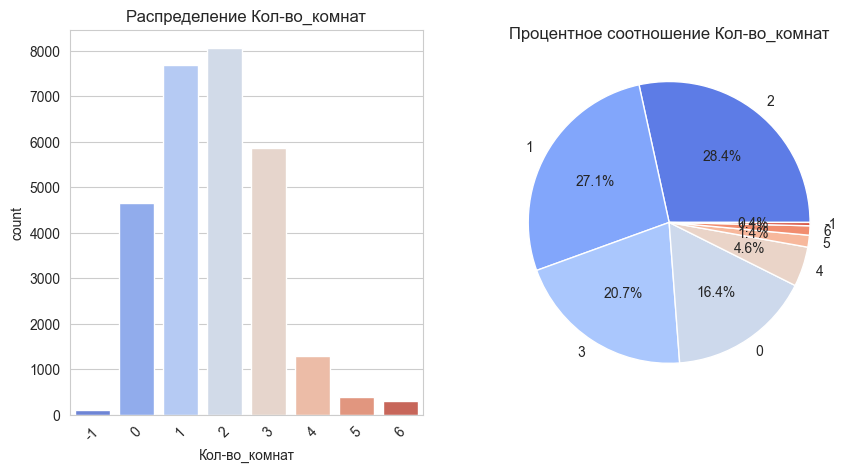

/var/folders/bm/39vh_d456d388sl7tv8xtz540000gn/T/ipykernel_52264/3068561441.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cian[col], palette="coolwarm")


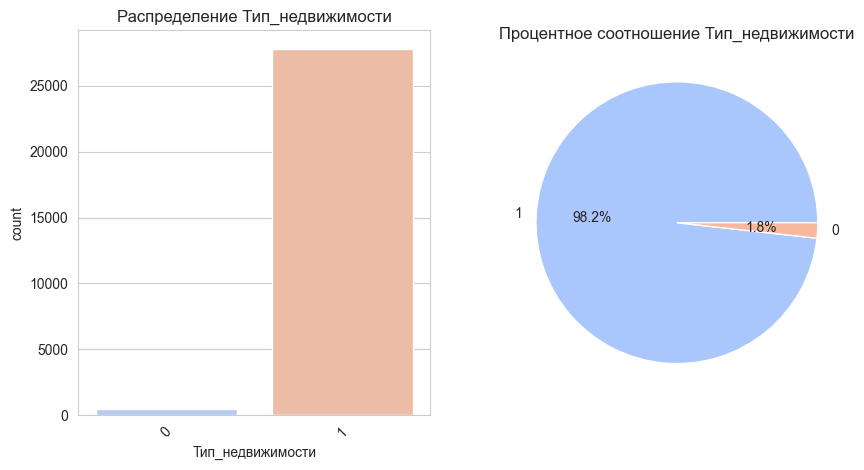

/var/folders/bm/39vh_d456d388sl7tv8xtz540000gn/T/ipykernel_52264/3068561441.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cian[col], palette="coolwarm")


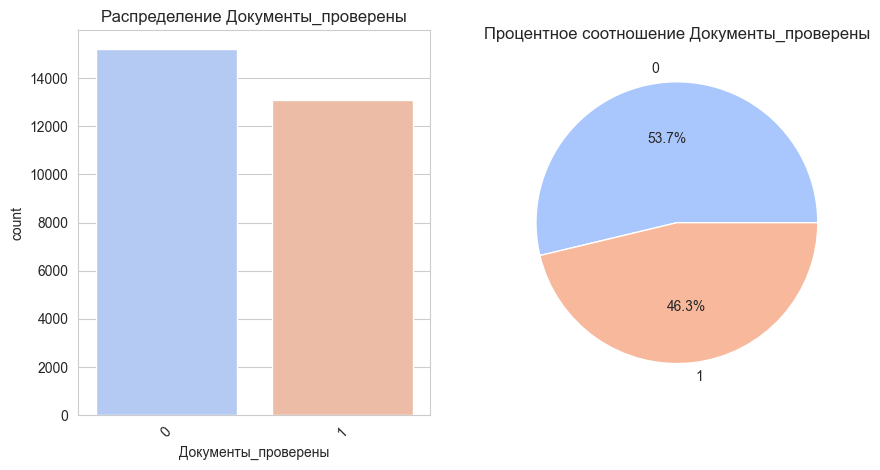

/var/folders/bm/39vh_d456d388sl7tv8xtz540000gn/T/ipykernel_52264/3068561441.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cian[col], palette="coolwarm")


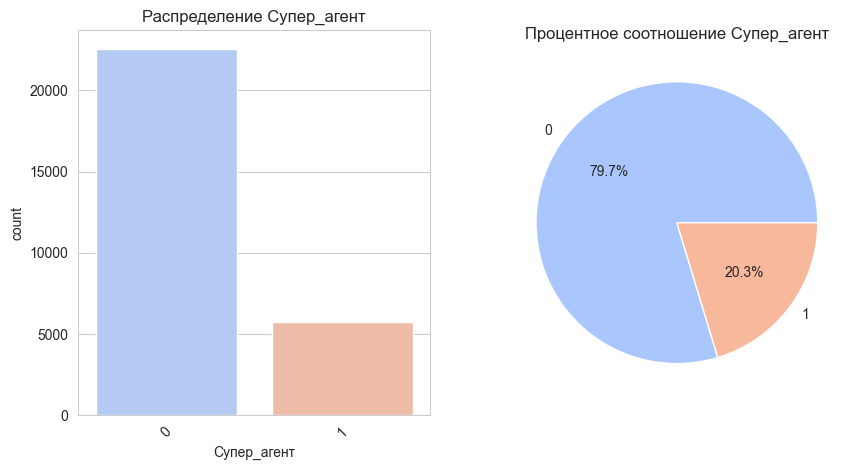

/var/folders/bm/39vh_d456d388sl7tv8xtz540000gn/T/ipykernel_52264/3068561441.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cian[col], palette="coolwarm")


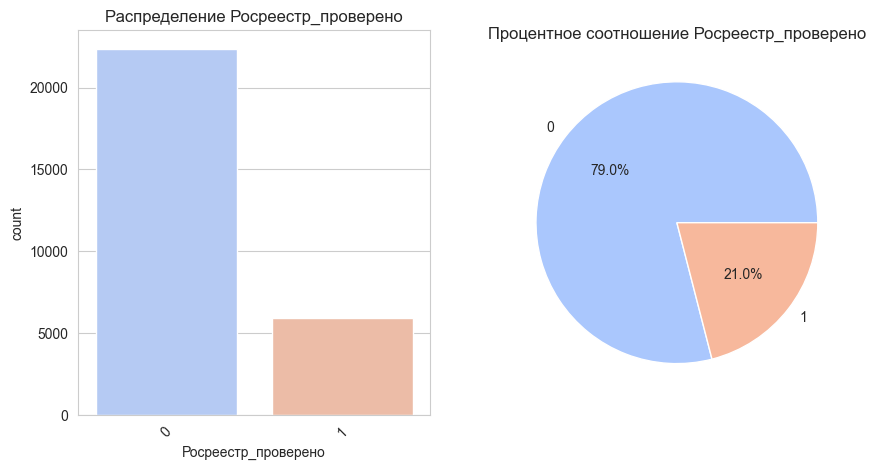

/var/folders/bm/39vh_d456d388sl7tv8xtz540000gn/T/ipykernel_52264/3068561441.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cian[col], palette="coolwarm")


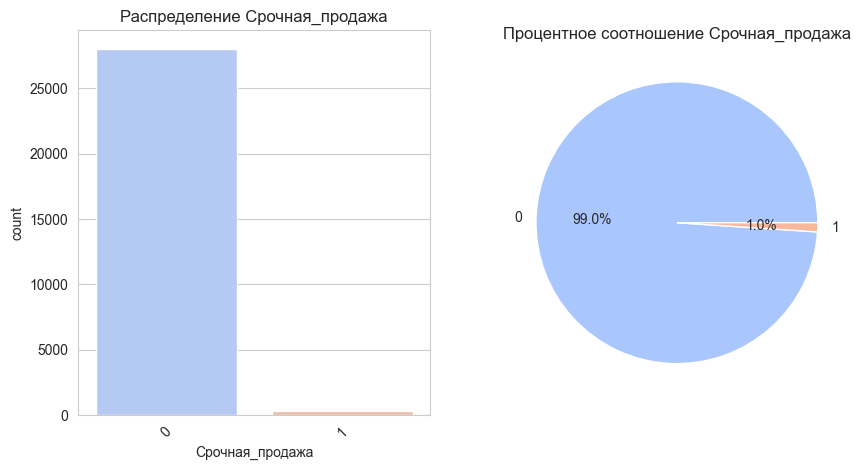

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Список категориальных столбцов
columns = ["Кол-во_комнат", "Тип_недвижимости", "Документы_проверены", 
           "Супер_агент", "Росреестр_проверено", "Срочная_продажа"]

# Создаём графики
for col in columns:
    plt.figure(figsize=(10, 5))

    # 1. Гистограмма (bar chart)
    plt.subplot(1, 2, 1)
    sns.countplot(x=cian[col], palette="coolwarm")
    plt.xticks(rotation=45)
    plt.title(f"Распределение {col}")

    # 2. Круговая диаграмма (pie chart)
    plt.subplot(1, 2, 2)
    cian[col].value_counts().plot(kind="pie", autopct="%.1f%%", colors=sns.color_palette("coolwarm", len(cian[col].unique())))
    plt.ylabel("")
    plt.title(f"Процентное соотношение {col}")

    plt.show()

/var/folders/bm/39vh_d456d388sl7tv8xtz540000gn/T/ipykernel_52264/460034123.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=cian["Кол-во_комнат"], y=cian["Цена_за_метр"], palette="coolwarm")


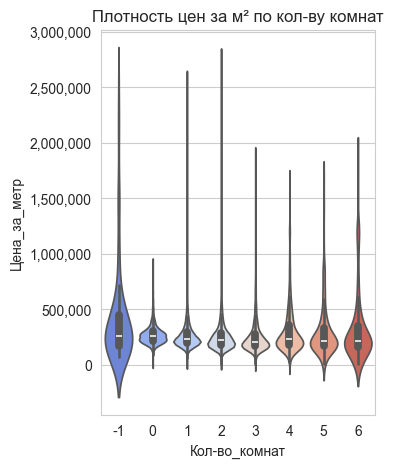

In [74]:
# Violin plot (плотность цен)

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 2)
sns.violinplot(x=cian["Кол-во_комнат"], y=cian["Цена_за_метр"], palette="coolwarm")
plt.title("Плотность цен за м² по кол-ву комнат")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

По графику мы видим, что каждый раздел кол-ва комнат имеет огромные выбросы (в основном выше 75 перцентиля), скорее всего это связано с тем, что Санкт 
Петербург - большой мегаполис, где встречаются очень престижные ЖК, которые мы видим на графике.